In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
from datetime import datetime
import schedule
import time
import os
import re
import subprocess
import pandas as pd
from pathlib import Path
import time
import threading


In [2]:
#save only 1 record per termal_zone
def thermal_zone():
    t_zone = [os.path.join(thermal, m.group(0)) for m in [re.search('thermal_zone[0-9]+', d) for d in os.listdir(thermal)] if m] 
    #t_zone = [filename for filename in os.listdir(thermal) if filename.startswith("thermal_zone")]
    return t_zone

def value(valor):
    val = (subprocess.check_output(['cat', valor]))
    return val

def thermal_temperature(zona):
    zona_temp = ([int(value(os.path.join(p, 'temp'))) for p in zona])

    return zona_temp

#save only 1 record per termal_zone
def save_thermal_temperature(zona, file):
    q = open(file, 'w')
    zona_temp = ([int(value(os.path.join(p, 'temp'))) for p in zona])
    
    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")   
    label = ""
    label = str("day")+";"+str("time")
    record = ""
    record = str(now).split(" ")[0]+";"+str(now).split(" ")[1]
    i=0
    for p in zona: 
        label += ";"+str(p.split("/")[-1])
        record +=";"+str(zona_temp[i])
        i+=1        
    record +=str('\n')
    q.write(str(label)+"\n")
    q.write(record)    
    q.close()
    
def get_all_thermal_zones():
    thermal_zones = []
    for folder in os.listdir('/sys/class/thermal/'):
        if folder.startswith('thermal_zone'):
            thermal_zones.append(os.path.join('/sys/class/thermal/', folder))
    return thermal_zones

def get_all_temperatures(thermal_zones):
    temperatures = []
    for zone_path in thermal_zones:
        temperature = get_temperature(zone_path)
        temperatures.append(temperature)
    return temperatures

def get_temperature(zone_path):
    with open(os.path.join(zone_path, 'temp'), 'r') as file:
        temperature = file.read().strip()
    return int(temperature) / 1000

def save_thermal_temperature(temporary_file, permanent_file, intervalo, duracao):
    thermal_zones = get_all_thermal_zones()
    tempo_total_execucao = duracao * 60  # Convertendo minutos para segundos
    inicio_execucao = time.time()

    # Verifica se o arquivo permanente já existe
    existe_arquivo_permanente = os.path.exists(permanent_file)

    with open(temporary_file, 'a') as q_temp:
        if not existe_arquivo_permanente:  # Se o arquivo permanente não existir
            label = "day;time;" + ";".join(zone.split('/')[-1] for zone in thermal_zones)
            q_temp.write(label + '\n')

        while time.time() - inicio_execucao < tempo_total_execucao:
            now = datetime.now().strftime("%Y-%m-%d;%H:%M:%S")  # Modificado para separar a data e a hora
            record = now.split(';')[0]  # Pegando apenas a data
            record += ';' + now.split(';')[1]  # Pegando apenas a hora

            temperatures = get_all_temperatures(thermal_zones)
            for temperature in temperatures:
                record += ';' + str(temperature)

            record += '\n'
            q_temp.write(record)
            time.sleep(intervalo * 60)

    # Copia o conteúdo do arquivo temporário para o arquivo permanente
    with open(temporary_file, 'r') as temp_file, open(permanent_file, 'a+') as perm_file:
        perm_file.write(temp_file.read())

    # Apaga os dados do arquivo temporário
    with open(temporary_file, 'w'):
        pass

    print("Coleta de temperaturas finalizadas.")

# Exemplo de uso
temporary_file = 'temperaturas_temporarias.csv'
permanent_file = 'historico_permanente_coletas_temperaturas.csv'
save_thermal_temperature(temporary_file, permanent_file, 1, 4)  # Coleta temperatura de todas as zonas térmicas a cada 1 minuto por 5 minutos




Coleta de temperaturas finalizadas.


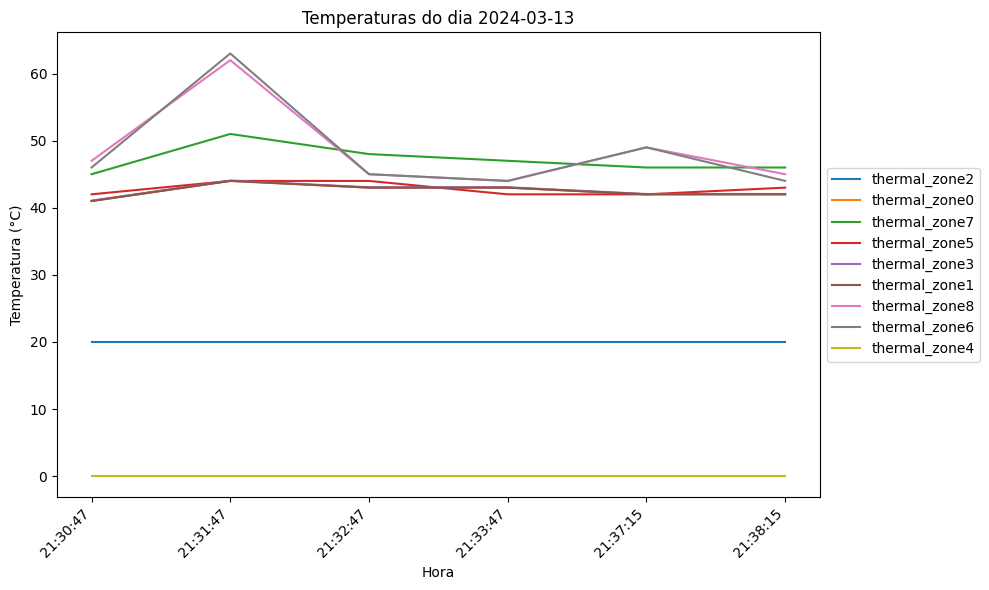

'def clear_permanent_file(permanent_file):\n    with open(permanent_file, \'r\') as file:\n        lines = file.readlines()\n\n    # Salva apenas a primeira linha (cabeçalho)\n    header = lines[0]\n\n    # Reescreve o arquivo com apenas o cabeçalho\n    with open(permanent_file, \'w\') as file:\n        file.write(header)\n\n    print("Dados do arquivo permanente foram apagados com sucesso, mantendo apenas o cabeçalho.")\n\n# Exemplo de uso\npermanent_file = "historico_permanente_coletas_temperaturas.csv"\n\nclear_permanent_file(permanent_file)\n'

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_temperature_graph(dataframe, day):
    # Filtra os dados para o dia específico
    df_day = dataframe[dataframe['day'] == day]

    # Configura o gráfico
    plt.figure(figsize=(10, 6))

    # Plota as temperaturas para cada zona térmica
    for column in df_day.columns[2:]:
        plt.plot(df_day['time'], df_day[column], label=column)

    # Adiciona título e rótulos aos eixos
    plt.title(f"Temperaturas do dia {day}")
    plt.xlabel("Hora")
    plt.ylabel("Temperatura (°C)")

    # Adiciona legenda
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Define o intervalo dos ticks no eixo x para evitar sobreposição
    plt.xticks(rotation=45, ha='right')

    # Exibe o gráfico
    plt.tight_layout()
    plt.show()

# Carrega os dados do arquivo CSV
file_path = "historico_permanente_coletas_temperaturas.csv"
df = pd.read_csv(file_path, delimiter=';')

# Escolha o dia específico para plotar o gráfico
day_to_plot = "2024-03-13"  # Substitua pelo dia desejado

# Plota o gráfico
plot_temperature_graph(df, day_to_plot)

'''def clear_permanent_file(permanent_file):
    with open(permanent_file, 'r') as file:
        lines = file.readlines()

    # Salva apenas a primeira linha (cabeçalho)
    header = lines[0]

    # Reescreve o arquivo com apenas o cabeçalho
    with open(permanent_file, 'w') as file:
        file.write(header)

    print("Dados do arquivo permanente foram apagados com sucesso, mantendo apenas o cabeçalho.")

# Exemplo de uso
permanent_file = "historico_permanente_coletas_temperaturas.csv"

clear_permanent_file(permanent_file)
'''

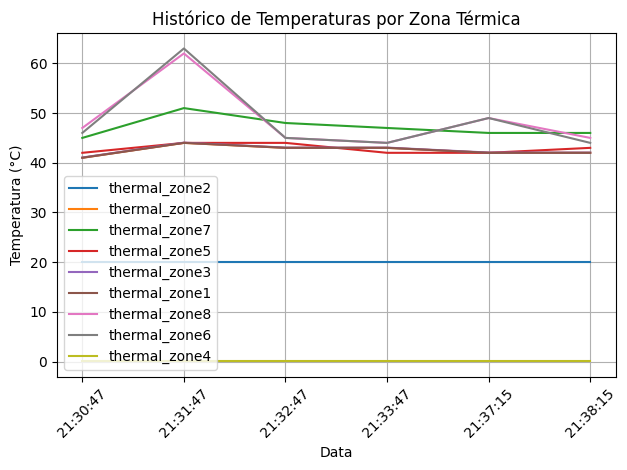

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar os dados do arquivo CSV
df = pd.read_csv('historico_permanente_coletas_temperaturas.csv', sep=';')

# Converter a coluna 'day' para o tipo datetime
df['day'] = pd.to_datetime(df['day'])

# Plotar um gráfico de linhas para cada zona térmica
for coluna in df.columns[2:]:  # Ignora as duas primeiras colunas (day e time)
    plt.plot(df['time'], df[coluna], label=coluna)

# Configurações adicionais do gráfico
plt.xlabel('Data')
plt.ylabel('Temperatura (°C)')
plt.title('Histórico de Temperaturas por Zona Térmica')
plt.legend()
plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo x para melhor visualização
plt.grid(True)

# Mostrar o gráfico
plt.tight_layout()
plt.show()

In [3]:
def save_info_proc_file(name_file ='info_proc.txt'):
    informacoes = {}
    
    with open('/proc/cpuinfo', 'r') as file:
        linhas = file.readlines()

    for linha in linhas:
        # Separa a linha em chave e valor
        partes = linha.strip().split(':')
        if len(partes) == 2:
            chave = partes[0].strip()
            valor = partes[1].strip()
            informacoes[chave] = valor

    with open(name_file, 'w') as file:
        for chave, valor in informacoes.items():
            file.write(f'{chave}: {valor}\n')

    print(f'Informações do processador salvas em {name_file}')


def print_several_temps_all_zones(file):
    df = pd.read_csv(file, sep=";", header=None)
    
    time_list = df[df.columns[1]].values.tolist()[1:]
    zones_dict = {}    
    all_zones_in_a_dictionary(zones_dict, df)
    print(zones_dict)
    zonesdict = zones_dict
    
    df = pd.DataFrame(data=zonesdict)
    df.index = time_list
    lines = df.plot.line(figsize=(10, 4))
    
#funcao nova
def all_zones_in_a_dictionary(zones_dict, df):

    for i in range(2, df.shape[1]):
        print("accessing position:", i)
        zone_name = df[df.columns[i]].values.tolist()[0]
        temp_list = df[df.columns[i]].values.tolist()[1:]
        temp_list_2 = [float(element) for element in temp_list]

        zones_dict[str(zone_name)] = temp_list_2
    return zones_dic

In [24]:

thermal = '/sys/class/thermal/'

def main():    
    output_file_unico = "temp_database.csv"
    output_file_varios = "temp_database_all.csv" 
    output_file_varios_teste = "temp_database_all.csv" 
    output_processor_info = "processor_info.csv"
    #Especifica a zona termal que se quer medir
    zona = thermal_zone()    
    #print(zona)
    #Salva as temperaturas de cada zona (1 unica vez)
    #save_thermal_temperature(zona, output_file_unico)
    
    # No futuro esta funcao vai ser chamada por 1 thread isolada    
    
    # Salvar as informacoes do processador
    thread1 = threading.Thread(target=save_processor_info, args=())
    thread1.start()
    
    # Salva as temperaturas de cada zona (1 registro por intervalo=segundo)
   # thread2 = threading.Thread(target=save_thermal_temperature_por_segundo, args=(zona, output_file_varios_teste, 10))
   # thread2.start()
    
    
    
    print("master doing thing 1")
    print("master doing thing 2")
    print("master doing thing 3")
    
    #save_thermal_temperature_por_segundo(zona, output_file_varios_teste,10)    # exemplo - save_thermal_temperature_por_segundo(zona, output_file_unico,10)
    
#     Printa grafico de linhas que exibe 1 temperatura por zona (arquivo output_file_unico)
#     chamada da funcao aqui
#     ex. print_single_temp(zona, output_file_unico)
#    print_single_temp(zona, output_file_unico)

#     # Printa grafico de linhas que exibe 10 temperaturas para cada zona termal (de 1 em 1)
#     # no intervalo de tempo especificado (usar o arquivo output_file_varios e printar os 10 ultimos minutos)
#     # chamada da funcao aqui
#     # ex. print_several_temps(output_file_unico, interval=10)
    
   # print_several_temps_all_zones(output_file_varios)
    
    
    
if __name__ == "__main__":
    main()

master doing thing 1
master doing thing 2
master doing thing 3
processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 166
model name	: Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz
stepping	: 0
microcode	: 0xf8
cpu MHz		: 2899.987
cache size	: 6144 KB
physical id	: 0
siblings	: 8
core id		: 0
cpu cores	: 4
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 22
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc art arch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc cpuid aperfmperf pni pclmulqdq dtes64 monitor ds_cpl vmx est tm2 ssse3 sdbg fma cx16 xtpr pdcm pcid sse4_1 sse4_2 x2apic movbe popcnt tsc_deadline_timer aes xsave avx f16c rdrand lahf_lm abm 3dnowprefetch cpuid_fault epb invpcid_single ssbd ibrs ibpb stibp ibrs_enhanced tpr_shadow flexpriority ept vpid ept_ad fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid mp